# Membership Inference Attacks Against Machine Learning Models

Elements of the adversarial system:
* Shadow model
* Attack model

###  Shadow Model

The adversary trains $k$ shadow models, each on a dataset (shadow data) that is similar
in format and distribution as the __target model's private training set__.

Generate shadow data drawing samples from the population where the target model's training data
are drawn from. The shadow model must be __trained in a similar fashion as the target model__.
The larger the number of shadow models, the better the accuracy of the attack model.

### Attack Model

The adversary queries each shadow model with its own disjoint training and test dataset which are of the __same size__.

# Generating training data for shadow models

The adversary needs training data that is distributed similarly to the target model's training data. 
Shoki's proposed methods are:

## Model-based synthesis:
*implementation can be found at data_synthesis.py*

Attacker does not have real raining data nor any statistics abouts its distribution.
Generate synthetic data for the shadow model using the target model itself. The intuition is that records that are classified by the target model 
with high confidence should be statistically similar to the target's training training dataset.

Two phases of synthesis process:
1. _Search_ using a hill-climbing algorithm the space of possible data records to find inputs that are classified by the target model with high confidence.
2. _Sample_ synthetic data from records. After synthetised a record, repeat until shadow dataset is full

>First fix class $c$ for which attacker wants to generate synthetic data.
Initialize randomly a data record $\mathbf{x}$.
The attacker must known the syntactic format of data records (number of features and numerical range of each feature).
Sample the value for each feature uniformly at random from among all possible values of that feature.

>A proposed record is _accepted_ only if it increases the [hill-climbing](https://en.wikipedia.org/wiki/Hill_climbing) objective: the probability of
being classified by the target model as class $c$.

>Each iteration involves proposing a new candidate record by changing $k$ randomly selected features of the latest accepted record $\mathbf{x^∗}$.
This is done by flipping binary features or resampling new values for features of other types.
We initialize $k$ to $k_{max}$ and divide it by 2 when $rej_{max}$ subsequent proposals are rejected. This controls the diameter of search around the
accepted record in order to propose a new record. We set the
minimum value of $k$ to $k_{min}$.
This controls the speed of the search for new records with a potentially higher classification
probability $y_c$.

>The second, sampling phase starts when the target model’s
probability $y_c$ that the proposed data record is classified as belonging to class $c$ is larger than the probabilities for all
other classes and also larger than a threshold $conf_{min}$.
This ensures that the predicted label for the record is $c$, and that the target model is sufficiently confident in its label prediction. We
select such record for the synthetic dataset with probability $y_{c}^∗$
and, if selection fails, repeat until a record is selected.

>This synthesis procedure works only if the adversary can
efficiently explore the space of possible inputs and discover
inputs that are classified by the target model with high confi-
dence. For example, it may not work if the inputs are high-
resolution images and the target model performs a complex
image classification task.


### Example with wine data:

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

get data, normalize and fit RF model

In [16]:
rf = RandomForestClassifier(n_estimators=100)
data, target = load_wine(return_X_y=True)

In [17]:
scaler = MinMaxScaler()
data_std = scaler.fit_transform(data)

In [18]:
rf.fit(data_std, target);

**synthesize** data and check if it belongs to the fixed class 

In [19]:
from mblearn import synthesize, synthesize_batch

In [20]:
# class we want the record to belong to
fixed_class = 1
# synth record
x = synthesize(rf, fixed_class=fixed_class, k_max=3)
# check if synth record is classified correctly
assert fixed_class == np.argmax(rf.predict_proba(x))

**batch mode**:

In [21]:
# Class to drawn samples from
fixed_class = 0
# num of records
n = 50

x0 = synthesize_batch(rf, fixed_class, n_records=n, k_max=3)
# some D-fence:
assert all(np.argmax(rf.predict_proba(x0), axis=1) == fixed_class)

In [22]:
# Class to drawn samples from
fixed_class = 1
# num of records
n = 50

x1 = synthesize_batch(rf, fixed_class, n_records=n, k_max=3)
# some D-fence:
assert all(np.argmax(rf.predict_proba(x1), axis=1) == fixed_class)

In [23]:
# Class to drawn samples from
fixed_class = 2
# num of records
n = 50

x2 = synthesize_batch(rf, fixed_class, n_records=n, k_max=3)
# some D-fence:
assert all(np.argmax(rf.predict_proba(x2), axis=1) == fixed_class)

Compare synthetic data and real data in a scatter plot

In [24]:
from sklearn.decomposition import PCA 

In [25]:
# concat original and synthetic data
all_data = np.concatenate((data_std, x0, x1, x2))

all_target = np.concatenate((target,
                             [3]*len(x0),
                             [4]*len(x1),
                             [5]*len(x2))
                           )

First project into 2D with PCA

In [26]:
pca = PCA()
data_proj = pca.fit_transform(all_data)

plot it

In [27]:
# Make a DataFrame with pca projection
all_df = pd.DataFrame(data_proj[:,:2], columns=['x', 'y'])
all_df['label'] = all_target

target_cat = {0:'cat0',
              1:'cat1',
              2:'cat2',
              3:'synth_0',
              4:'synth_1',
              5:'synth_2'}

all_df.label = all_df.label.map(target_cat)

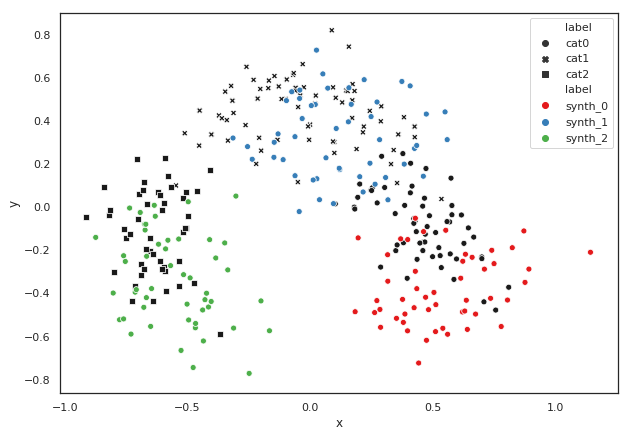

In [28]:
plt.figure(figsize=(10,7))
df_orig = all_df[np.isin(all_df.label, ['cat0', 'cat1', 'cat2'])]
sns.scatterplot(df_orig.x, df_orig.y, style=df_orig.label, color='k')
df_synth = all_df[np.isin(all_df.label, ['synth_0', 'synth_1', 'synth_2'])]
sns.scatterplot('x', 'y', hue='label', data=df_synth, palette='Set1')

looks good to me (งᗒ▾ᗕ)ง

In [15]:
#save synthetic data
synth_data = np.concatenate((x0, x1, x2))
df_synth = pd.DataFrame(synth_data) 
df_synth['label'] = np.concatenate(([0]*len(x0),[1]*len(x1),[2]*len(x2)))
df_synth.to_csv('synthetic_data.csv', index=False)

---

## Statistics-based synthesis

>The attacker may have some statistical information about the population from which the target
model’s training data was drawn.
For example, the attacker may have prior knowledge of the marginal distributions of different features.
In our experiments, we generate synthetic training records for the shadow models by independently
sampling the value of each feature from its own marginal distribution.
The resulting attack models are very effective.

## Noisy real data

>The attacker may have access to some data
that is similar to the target model’s training data and can be
considered as a “noisy” version thereof. In our experiments
with location datasets, we simulate this by flipping the (binary)
values of 10% or 20% randomly selected features,
then raining our shadow models on the resulting noisy dataset.
This scenario models the case where the training data for the
target and shadow models are not sampled from exactly the
same population, or else sampled in a non-uniform way.